In [1]:
%reload_ext autoreload
%autoreload 2

from pyneurode.spike_sorter import *
import numpy as np 
import pickle
from sklearn import metrics
from tqdm.notebook import tqdm
import seaborn as sns
from utils import *
from RingBuffer import RingBuffer
from sklearn import preprocessing
from sklearn import *
from scipy import signal 
from imblearn.over_sampling import RandomOverSampler

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
agg_buffer = RingBuffer.readPickleStreamFile('../data/agg_buffer.pkl')

Total segment read: 305


(3355, 14)


(0.0, 2000.0)

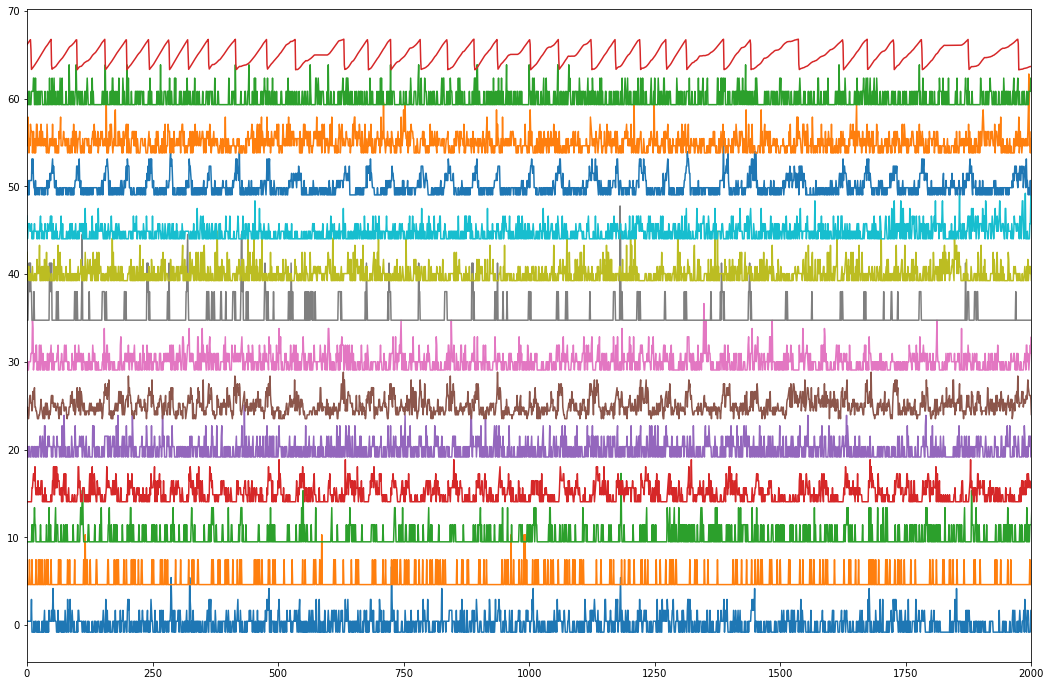

In [3]:
plt.figure(figsize=(18,12))
# signal2plot=np.hstack([norm_spiketrain,norm_pos_online])
scaler =preprocessing.StandardScaler()
print(agg_buffer.shape)
norm_agg_buffer = scaler.fit_transform(agg_buffer)

plot_multichannel(norm_agg_buffer.T,scale=5)
plt.xlim([0,2000])

### Decode

In [4]:
def makeSlidingWinFeature(x,win):
    feat = np.zeros((x.shape[0]-win+1,x.shape[1]*win))
    
    for i in range(x.shape[0]-win+1):
        feat[i,:] = x[i:i+win,:].ravel()
    return feat

y = np.ceil(np.random.rand(10,3)*10)
print(y)
x=makeSlidingWinFeature(y,4)
print(x)
print(x.shape)

[[ 4.  4.  7.]
 [ 5.  3.  9.]
 [ 6.  1.  4.]
 [ 9.  2. 10.]
 [ 8.  7.  5.]
 [ 5. 10. 10.]
 [ 2. 10.  2.]
 [10.  9.  2.]
 [ 3.  3.  2.]
 [ 9.  7.  6.]]
[[ 4.  4.  7.  5.  3.  9.  6.  1.  4.  9.  2. 10.]
 [ 5.  3.  9.  6.  1.  4.  9.  2. 10.  8.  7.  5.]
 [ 6.  1.  4.  9.  2. 10.  8.  7.  5.  5. 10. 10.]
 [ 9.  2. 10.  8.  7.  5.  5. 10. 10.  2. 10.  2.]
 [ 8.  7.  5.  5. 10. 10.  2. 10.  2. 10.  9.  2.]
 [ 5. 10. 10.  2. 10.  2. 10.  9.  2.  3.  3.  2.]
 [ 2. 10.  2. 10.  9.  2.  3.  3.  2.  9.  7.  6.]]
(7, 12)


0.5369866938038721 0.5370063630628368 0.44801786043133396


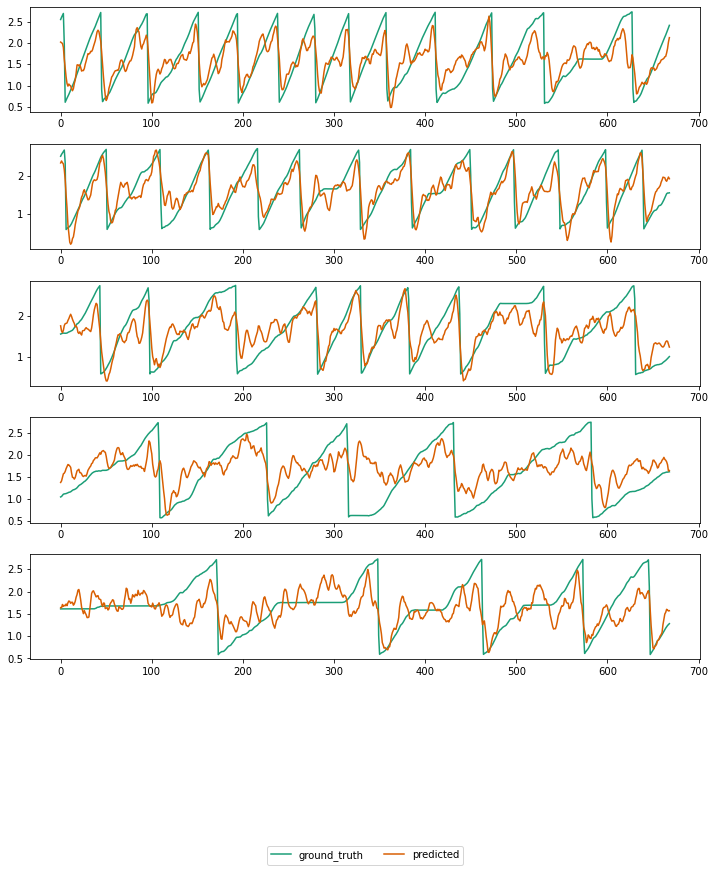

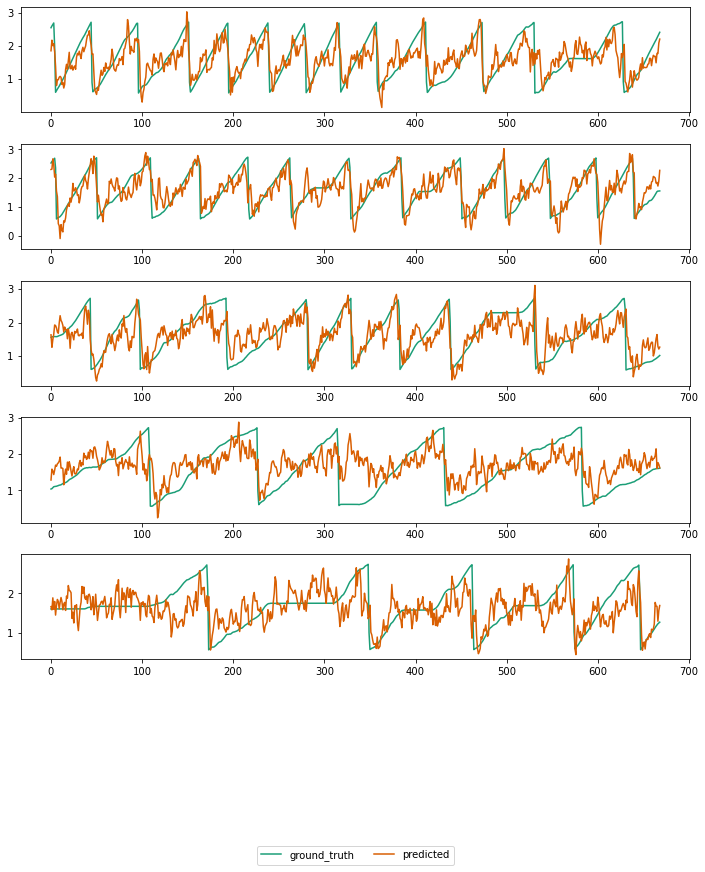

In [5]:

spk_train = agg_buffer[:,:-1]
pos = agg_buffer[:,-1]

scaler =preprocessing.StandardScaler()
norm_spk_train = scaler.fit_transform(spk_train)

#make sliding window
slidWin = 5
norm_spk_train = makeSlidingWinFeature(norm_spk_train,slidWin)
pos = pos[slidWin-1:]

polyFeatures = preprocessing.PolynomialFeatures(1).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)
# poly_spiketrain= norm_spk_train

# regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,pos)
regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')
regressor.fit(poly_spiketrain,pos)

predicted = model_selection.cross_val_predict(regressor,poly_spiketrain,pos.ravel(),cv=5)
# predicted = model_selection.cross_val_predict(regressor,poly_spiketrain_ms4,norm_pos_online,cv=4)
predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
r2 = metrics.r2_score(pos.squeeze(),predicted_smooth.ravel())
varExplain = metrics.explained_variance_score(pos.squeeze(),predicted_smooth.ravel())
varExplainRaw = metrics.explained_variance_score(pos.squeeze(),predicted.ravel())

print(r2,varExplain,varExplainRaw)
stripplot(pos,predicted_smooth,figsize=(12,12));
stripplot(pos,predicted,figsize=(12,12));


### Accuracy vs position

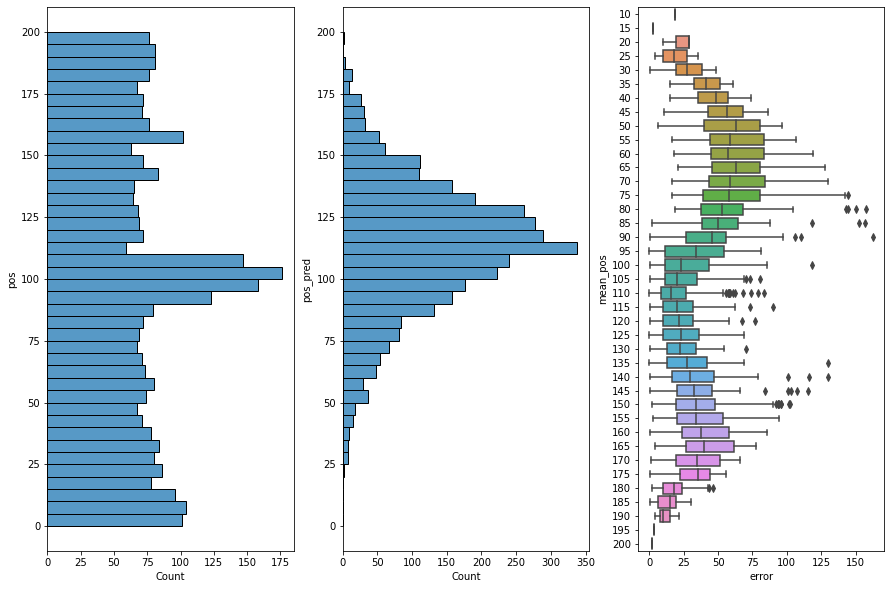

In [6]:
pos_scaled = preprocessing.minmax_scale(pos,(0,200))
predicted_scaled = preprocessing.minmax_scale(predicted,(0,200))
bins = np.arange(0,205,5)
pos_binned = np.digitize(pos_scaled,bins,right=True)
error = np.abs(pos_scaled-predicted_scaled)
df = pd.DataFrame({'pos_binned':bins[pos_binned],'error':error})

mean_pos = (predicted_scaled+pos_scaled)/2
df['mean_pos'] = bins[np.digitize(mean_pos,bins)]

df['pos_pred'] = predicted_scaled
df['pos'] = pos_scaled

fig,ax = plt.subplots(1,3,figsize=(15,10))
sns.histplot(y='pos',binwidth=5,data=df,ax=ax[0])
sns.histplot(y='pos_pred',binwidth=5,data=df,ax=ax[1])
sns.boxplot(y='mean_pos',x='error',orient='h',data=df,ax=ax[2]);
# sns.swarmplot(y='mean_pos',x='error',orient='h',data=df,ax=ax[1],color='.25')

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


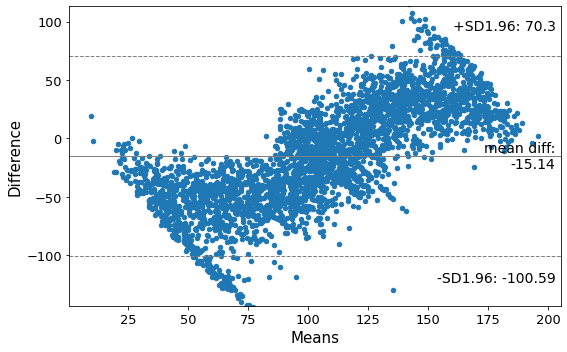

In [7]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(pos_scaled, predicted_scaled, ax = ax);

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


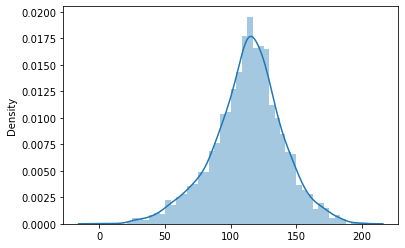

In [8]:
ax=sns.distplot(predicted_scaled)

### Classification approach

In [9]:
#use a classificaiton approach instead

spk_train = agg_buffer[:,:-1]
pos = agg_buffer[:,-1]

scaler =preprocessing.StandardScaler()
norm_spk_train = scaler.fit_transform(spk_train)

#make sliding window
slidWin = 5
norm_spk_train = makeSlidingWinFeature(norm_spk_train,slidWin)
pos = pos[slidWin-1:]

# bin the position into classes
pos_scaled = preprocessing.minmax_scale(pos,(0,200))
bins = np.arange(0,205,10)
pos_binned = np.digitize(pos_scaled,bins)

polyFeatures = preprocessing.PolynomialFeatures(1).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)
# poly_spiketrain= norm_spk_train


# regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,pos)
classifier = svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True)
# classifier.fit(poly_spiketrain,pos_binned)

accu=model_selection.cross_val_score(classifier,poly_spiketrain,pos_binned,cv=5)

print(np.mean(accu))


C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.29960851480303397


C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Text(0.5, 69.0, 'Predicted label')

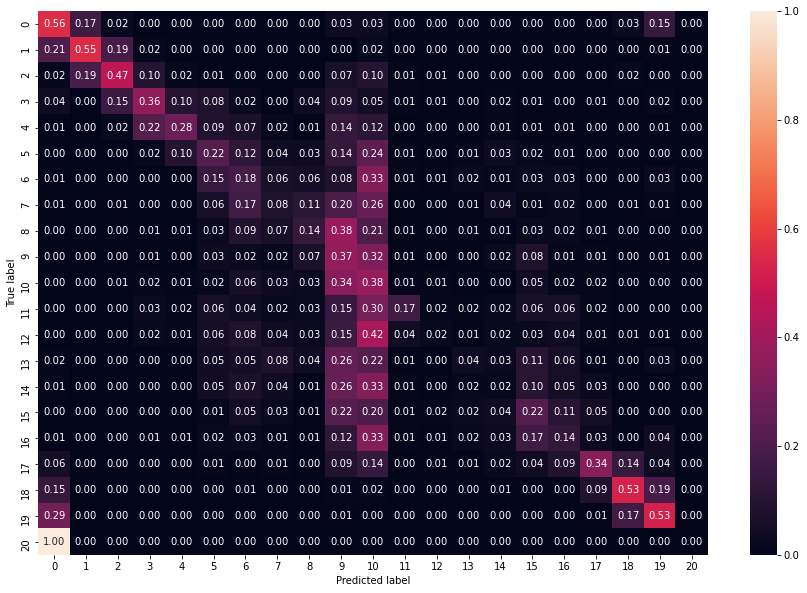

In [10]:
plt.figure(figsize=(15,10))
predicted = model_selection.cross_val_predict(classifier,poly_spiketrain,pos_binned,cv=5)
m = metrics.confusion_matrix(pos_binned,predicted,normalize='true') #row is true
ax=sns.heatmap(m,annot=True,fmt='.2f')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

0.2423527399047284


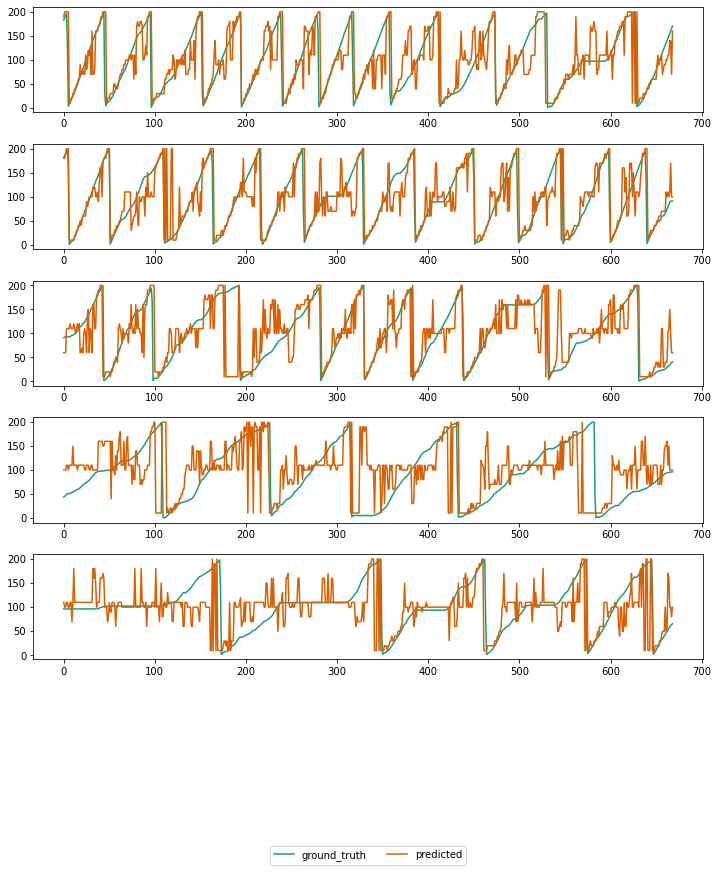

In [11]:
stripplot(pos_scaled,bins[predicted],figsize=(12,12));
varExplain = metrics.explained_variance_score(pos_binned.squeeze(),predicted.ravel())
print(varExplain)

In [9]:
# classification probability
predicted_prob = model_selection.cross_val_predict(classifier,poly_spiketrain,pos_binned,cv=5,method='predict_proba')
predicted_pos = model_selection.cross_val_predict(classifier,poly_spiketrain,pos_binned,cv=5)

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\sklearn\model_selection\_validation.py:905: RuntimeWarning: Number of classes in training fold (20) does not match total number of classes (21). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


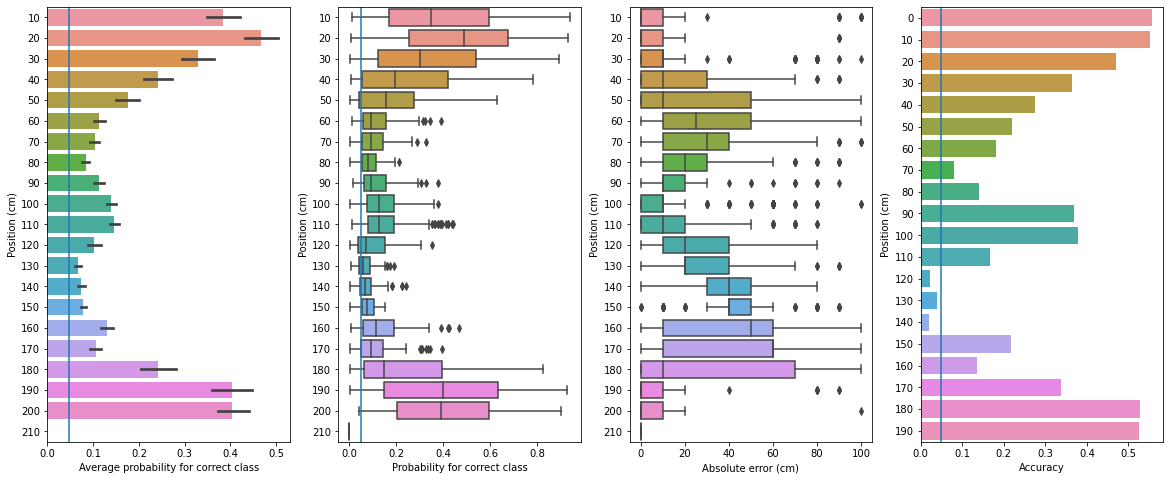

In [10]:
# classification probability vs location

true_class_prob = np.take_along_axis(predicted_prob,(pos_binned-1)[:,None],axis=1)
error = np.abs((predicted_pos-pos_binned))*10
error[error>100] = 200 - error[error>100]
#since 200 and 0 are next to each other, so we change the position to an angle
# plot the firing rate in a circle

df_class = pd.DataFrame({'prob':true_class_prob.ravel(), 'pos':(pos_binned)*10, 'error': error})

fig,ax = plt.subplots(1,4,figsize=(20,8))
axIdx = 0
sns.barplot(x='prob',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Average probability for correct class')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])

# fig,ax = plt.subplots(1,1,figsize=(10,8))
axIdx += 1
sns.boxplot(x='prob',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Probability for correct class')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])

axIdx += 1
sns.boxplot(x='error',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Absolute error (cm)')
ax[axIdx].set_ylabel('Position (cm)');



# accuracy for each position
axIdx +=1
accuracy = []
for i in range(predicted_prob.shape[1]-1):
    idx = (pos_binned==i+1) #pos_binned is from 1 to 21
    accuracy.append(np.mean(pos_binned[idx] == predicted_pos[idx]))

sns.barplot(y=np.arange(0,200,10),x=accuracy,orient='h',ax=ax[axIdx])
ax[axIdx].set_xlabel('Accuracy')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])


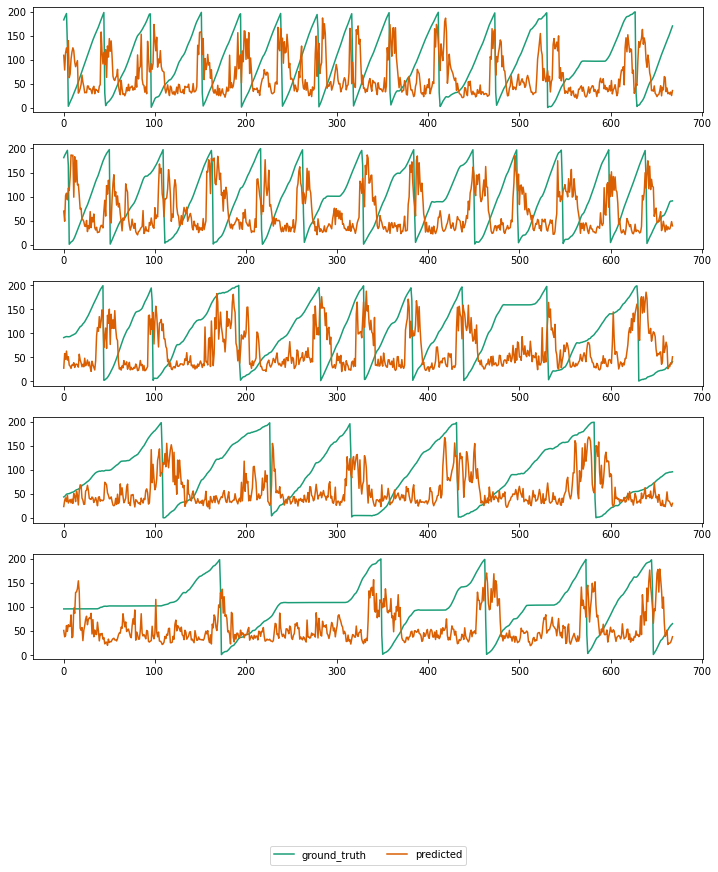

In [11]:
stripplot(pos_scaled,np.max(predicted_prob,axis=1)*200,figsize=(12,12));


### Kalman filter

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\pykalman\utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


0.4004295479259633 0.44801786043133396


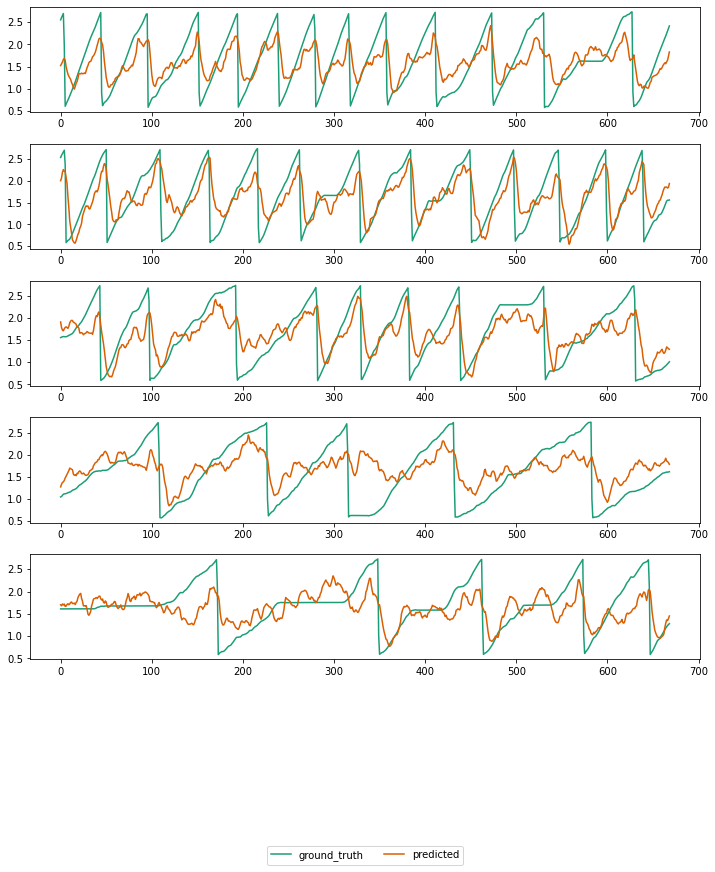

In [29]:
# Kalman filter smoothing
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices=np.array([[1, 0.001,0.001], [0, 1,0.1],[0,0,1]]),
                  transition_covariance=0.001 * np.eye(3),
                    observation_covariance = 5)
kf = kf.em(predicted)
state_pred = kf.filter(predicted)[0]

stripplot(pos,state_pred[:,0],figsize=(12,12));

varExplain = metrics.explained_variance_score(pos,state_pred[:,0].ravel())
varExplainRaw = metrics.explained_variance_score(pos,predicted.ravel())

print(varExplain,varExplainRaw)


In [104]:
np.std(pos -predicted)

0.4573757671248346

0.4145213185389074 0.449096287823046


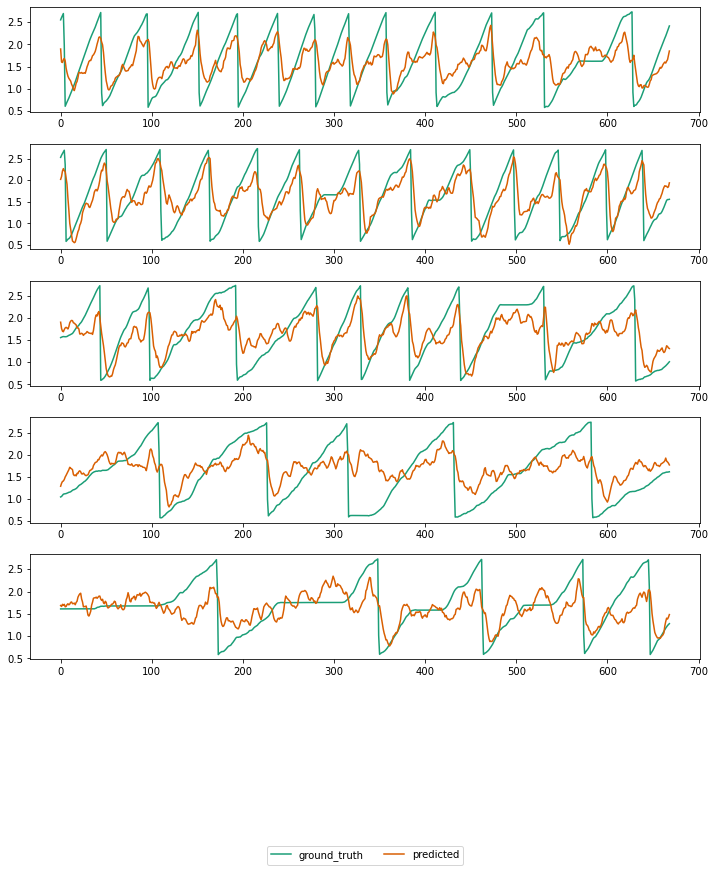

In [105]:
# stripplot(predicted[:200],state_pred[:200,0],figsize=(12,12));
# stripplot(predicted,state_pred[:,0],figsize=(12,12));
stripplot(pos,state_pred[:,0],figsize=(12,12));

varExplain = metrics.explained_variance_score(pos,state_pred[:,0].ravel())
varExplainRaw = metrics.explained_variance_score(pos,predicted.ravel())

print(varExplain,varExplainRaw)

0.4425986151759781


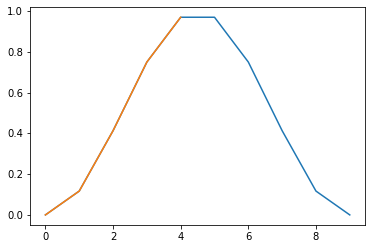

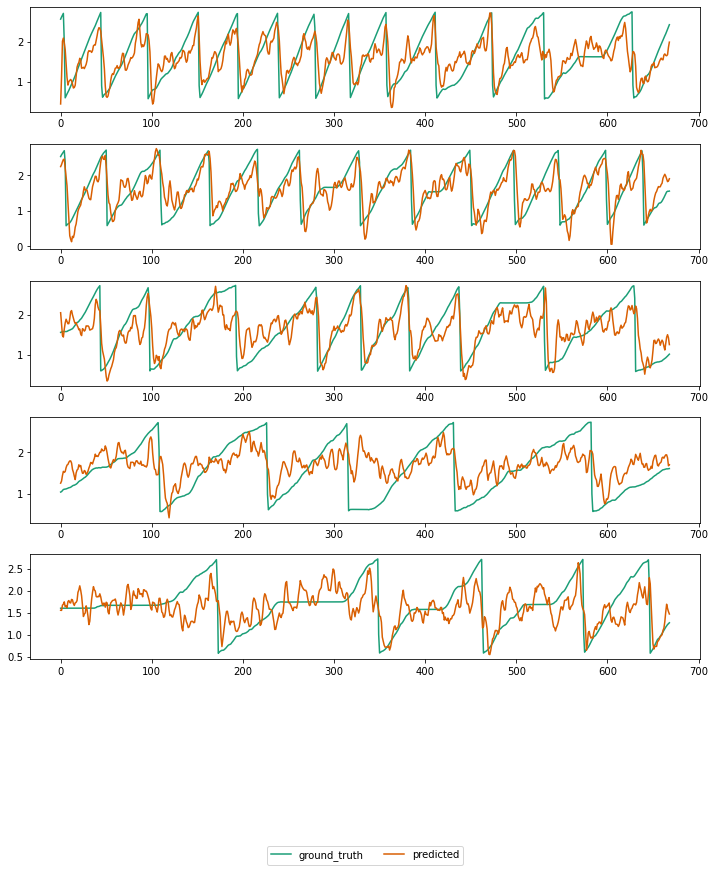

In [142]:
window = np.hanning(10)
plt.plot(window)
window = window[:len(window)//2]
plt.plot(window)
predicted_smooth = np.convolve(predicted,window/window.sum(),mode='same')
stripplot(pos,predicted_smooth,figsize=(12,12));
varExplain = metrics.explained_variance_score(pos,predicted_smooth.ravel())
print(varExplain)

-0.2843568087343207


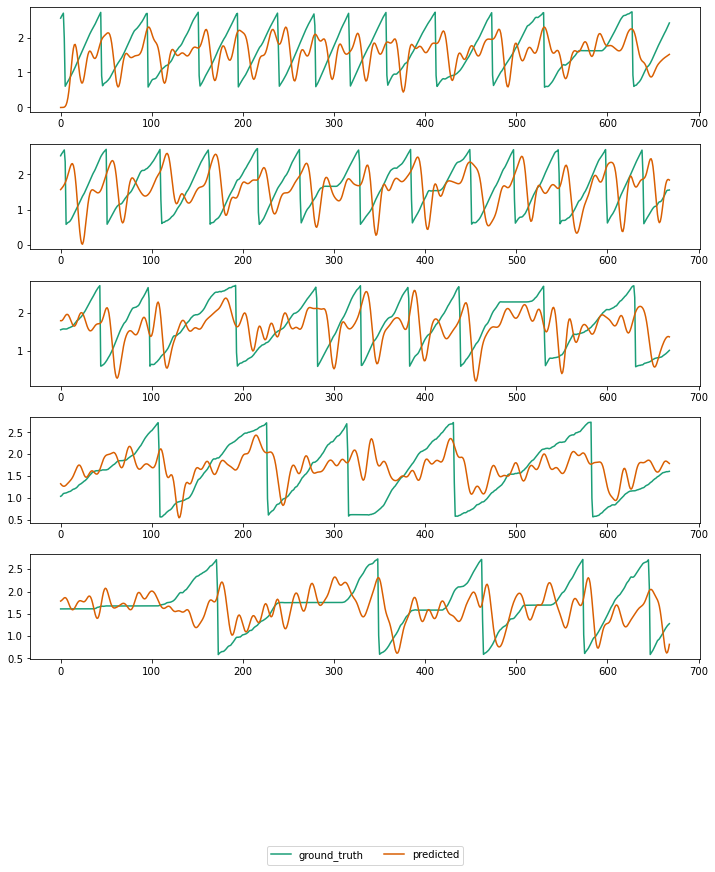

In [147]:
sos=signal.butter(8,3/(10*2),'low',output='sos')
predicted_smooth = signal.sosfilt(sos,predicted)
stripplot(pos,predicted_smooth,figsize=(12,12));
varExplain = metrics.explained_variance_score(pos,predicted_smooth.ravel())
print(varExplain)

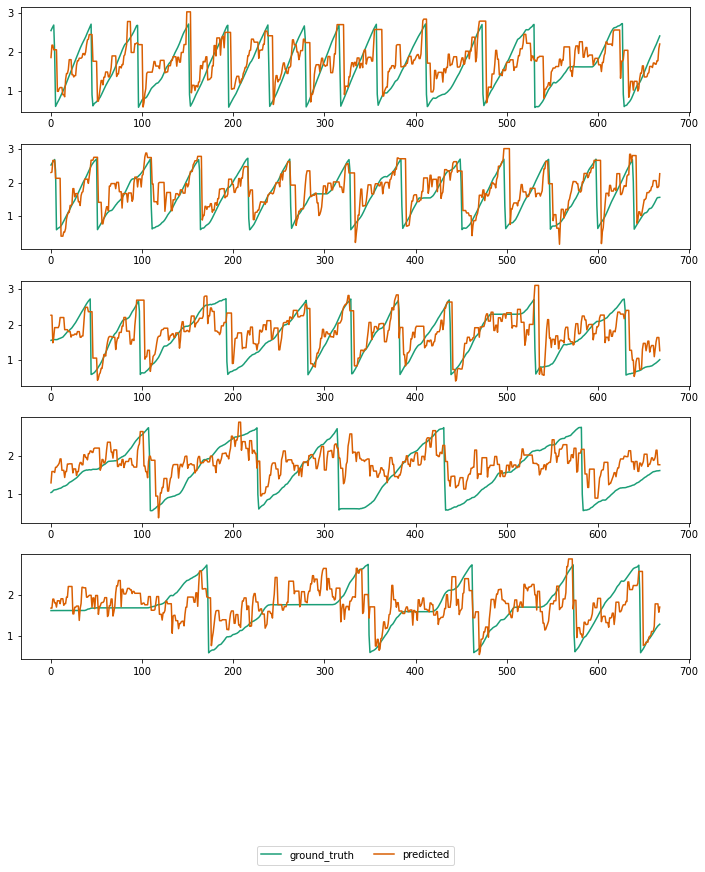

In [113]:
# very simple filtering
predicted_smooth = predicted.copy()
speed = np.diff(predicted,prepend=predicted[0])

for i in range(len(predicted_smooth)):
    if(predicted_smooth[i]<predicted_smooth[i]):
        predicted_smooth[i]=lastpos
    else:
        lastpos=predicted_smooth[i]

stripplot(pos,predicted_smooth,figsize=(12,12));


### Effect of sliding window

In [36]:
spk_train = agg_buffer[:,:-1]
pos = agg_buffer[:,-1]

scaler =preprocessing.StandardScaler()
norm_spk_train = scaler.fit_transform(spk_train)

#make sliding window
slidWin_list = range(1,20)
varExplainRaw_list = []
varExplainSmooth_list = []

for win in tqdm(slidWin_list):
    
    norm_spk_train_exp = makeSlidingWinFeature(norm_spk_train,win)
    pos_exp = pos[win-1:]

#     polyFeatures = preprocessing.PolynomialFeatures(1).fit(norm_spk_train)
#     poly_spiketrain = polyFeatures.transform(norm_spk_train)
    poly_spiketrain= norm_spk_train_exp
    print(poly_spiketrain.shape)

    # regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,pos)
    regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')
    regressor.fit(poly_spiketrain,pos_exp)

    predicted = model_selection.cross_val_predict(regressor,poly_spiketrain,pos_exp.ravel(),cv=5)
    # predicted = model_selection.cross_val_predict(regressor,poly_spiketrain_ms4,norm_pos_online,cv=4)
    predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
    r2 = metrics.r2_score(pos_exp.squeeze(),predicted_smooth.ravel())
    varExplain = metrics.explained_variance_score(pos_exp.squeeze(), predicted_smooth.ravel())
    varExplainRaw = metrics.explained_variance_score(pos_exp.squeeze(), predicted.ravel())
    
    varExplainRaw_list.append(varExplainRaw)
    varExplainSmooth_list.append(varExplain)

(3355, 13)
(3354, 26)
(3353, 39)
(3352, 52)
(3351, 65)
(3350, 78)
(3349, 91)
(3348, 104)
(3347, 117)
(3346, 130)
(3345, 143)
(3344, 156)
(3343, 169)
(3342, 182)
(3341, 195)
(3340, 208)
(3339, 221)
(3338, 234)
(3337, 247)



TODO
- Need to prevent the position going up and down
- Need to know the certainty of the regression output
- 

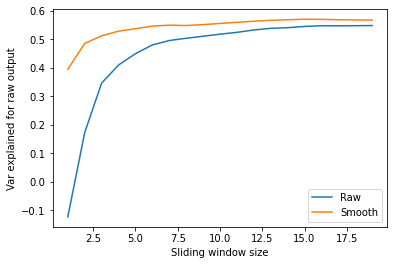

In [40]:
plt.plot(slidWin_list,varExplainRaw_list,label='raw')
plt.plot(slidWin_list,varExplainSmooth_list,label='smooth')

plt.xlabel('Sliding window size')
plt.ylabel('Var explained for raw output');
plt.legend(['Raw','Smooth']);

### Decode speed as well

(3041, 820)
-0.006864081462642613 -0.0030932199971327456 -0.0030928044359668228


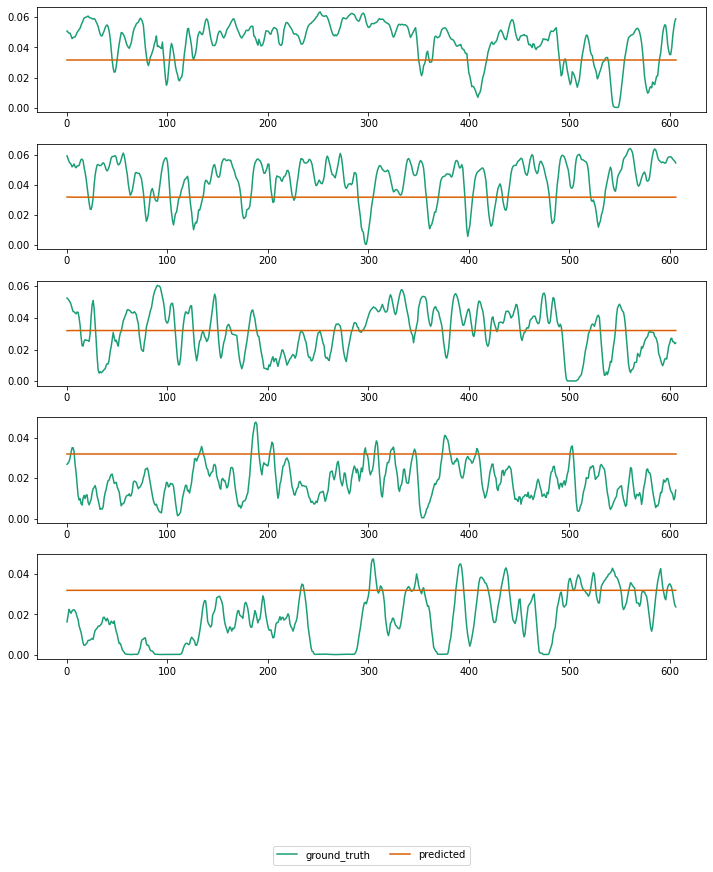

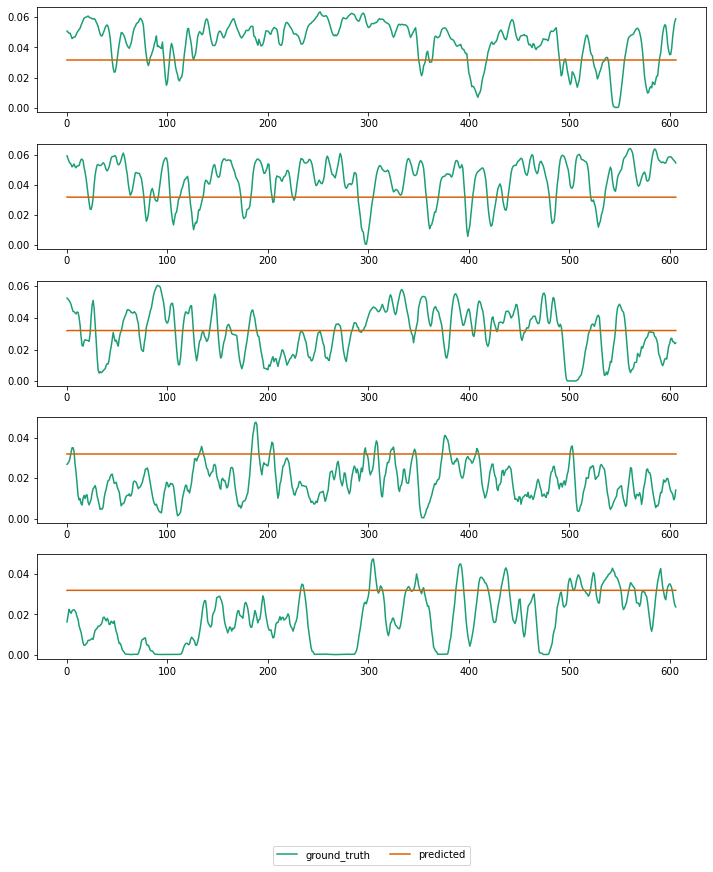

In [92]:
spk_train = agg_buffer[:,:-1]
pos = agg_buffer[:,-1]

scaler =preprocessing.StandardScaler()
norm_spk_train = scaler.fit_transform(spk_train)

# Discard data at the end of the track when the position reset, the speed is not correct there
speed = np.diff(pos, prepend=pos[0])
idx = np.where(speed>=0)[0]
norm_spk_train = norm_spk_train[idx,:]
speed = speed[idx]
speed = signal.savgol_filter(speed.ravel(),5,1)

#make sliding window
slidWin = 3
norm_spk_train = makeSlidingWinFeature(norm_spk_train,3)
speed = speed[slidWin:]

# speed_scaler = preprocessing.StandardScaler()
# speed = speed_scaler.fit_transform(speed.reshape(-1,1))

polyFeatures = preprocessing.PolynomialFeatures(2).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)
# poly_spiketrain = norm_spk_train
print(poly_spiketrain.shape)


# regressor = linear_model.Lasso(alpha=0.1)
# regressor = linear_model.LinearRegression()
regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')
regressor.fit(poly_spiketrain,speed)

predicted = model_selection.cross_val_predict(regressor,poly_spiketrain,speed.ravel(),cv=5)
# predicted = model_selection.cross_val_predict(regressor,poly_spiketrain_ms4,norm_pos_online,cv=4)
predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
r2 = metrics.r2_score(speed.squeeze(),predicted_smooth.ravel())
varExplain = metrics.explained_variance_score(speed.squeeze(),predicted_smooth.ravel())
varExplainRaw = metrics.explained_variance_score(speed.squeeze(),predicted.ravel())

print(r2,varExplain,varExplainRaw)
stripplot(speed,predicted_smooth,figsize=(12,12));
stripplot(speed,predicted,figsize=(12,12));

(0.0, 100.0)

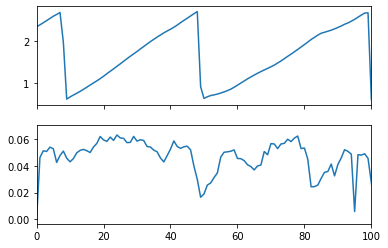

In [36]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(pos)
ax[1].plot(speed)
plt.xlim([0,100])

In [46]:
for i in range(norm_spk_train.shape[1]):
    coeff = np.corrcoef(norm_spk_train[:,i],speed)
    print(coeff[0,1])

0.09838525763793092
0.024901614226663392
-0.03515058454658835
0.19132503887265254
0.050338545737961087
-0.060182586972119964
-0.015692808190727842
0.07693751601314032
0.07314766432631813
-0.1461599769559328
-0.032415092963622646
0.014877251500087684
-0.020296328781757515


### Effect of training samples

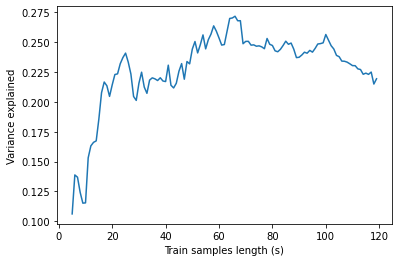

In [5]:
scores = []
data_length = []
time_bin = 0.1
# regressor = linear_model.Lasso(alpha=0.1)
regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')
train_num_list = range(5,120)

polyFeatures = preprocessing.PolynomialFeatures(2).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)

for train_num in train_num_list:
    #create training and testing set
    train_idx = range(int(train_num*(1/time_bin)))
    test_idx = np.setdiff1d(range(poly_spiketrain.shape[0]),train_idx)
    assert len(np.intersect1d(train_idx,test_idx)) == 0
    
    # fit and predict
    regressor.fit(poly_spiketrain[train_idx,:], pos[train_idx])
    predicted = regressor.predict(poly_spiketrain[test_idx,:])

    predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
    varExplain = metrics.explained_variance_score(pos[test_idx],predicted_smooth)
    
    scores.append(varExplain)

plt.plot(train_num_list, scores)
plt.xlabel('Train samples length (s)')
plt.ylabel('Variance explained');

### Do some feature selection as well as parameter search